In [1]:
%matplotlib inline
                                
import matplotlib.pyplot as plt

import torch.nn as nn

# from fastai.vision import ConvLearner 
from fastai import vision
import fastai
from torchsummary import summary

from PIL import Image
import requests

from tqdm import tqdm

from fastai import torch_core

import torchvision.models as tvm
from torch.utils.data import Dataset, DataLoader
import torch

import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose([transforms.ToTensor()])

In [38]:
trainset = torchvision.datasets.MNIST(root='./data/mnist', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, 
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data/mnist', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

In [4]:
import torch.nn.functional as F

import torch.nn as nn
from functools import reduce
import torch.optim as optim

class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.size(0), -1)
    
class Reshape(nn.Module):
    def __init__(self, shape):
        super(Reshape, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(x.size(0), *self.shape)

In [5]:
# # embedding
class Classifier(nn.Module):
    def __init__(self, embedding_net, no_classes=10, verbose=False):
        super(Classifier, self).__init__()   
        self.embedding = embedding_net
        self.classifier = nn.Sequential(
            nn.Linear(2, no_classes),
            nn.LogSoftmax(dim=1)
        )
        self.loss =  nn.NLLLoss()
        
    def forward(self, x):
        return self.classifier(self.get_embedding(x))
    
    def get_embedding(self, x):
        return self.embedding(x)
    

class Embedding(nn.Module):
    def __init__(self, latent_dims=2, verbose=False):
        super(Embedding, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 6, 5),
            nn.PReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 5),
            nn.PReLU(),
            nn.MaxPool2d(2, 2),
            Flatten(),
            nn.Linear(256, 128),
            nn.PReLU(),
            nn.Linear(128, latent_dims),
            nn.PReLU(),
        )

    def forward(self, x):
        return self.encoder(x)

# Embedding model

In [47]:
model = Classifier(Embedding(latent_dims=2), 10)

In [48]:
def train(model, trainloader, testloader, log_interval=150, total_epochs=1, lr=0.001):
    stats_collector = dict(
        train_loss = [],
        train_acc = [],
        val_loss = [],
        val_acc = []
    )
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    total_loop = total_epochs * len(list(trainloader))
    no_test_samples = len(list(testloader))

    with tqdm(total=total_loop) as pbar:
        status =dict(
            epoch=0,
            train_loss=0.0,
            train_acc=0.0,
            val_loss=-1,
            val_acc=-1
        )
        pbar.set_postfix(status)

        for epoch in range(total_epochs):
            status['epoch'] = epoch
            sample_seen = 0.0
            running_loss = 0.0
            running_acc =  0.0

            # train
            model.train()
            for i, data in enumerate(trainloader, 0):
                x, y = data

                optimizer.zero_grad()

                y_hat = model(x)

                loss = model.loss(y_hat, y)
                bins = list(np.argmax(y_hat, axis=1) == y)
                running_acc += np.sum(bins)
                running_loss += loss.detach().numpy() * x.shape[0]
                sample_seen += y_hat.shape[0]
                loss.backward()
                optimizer.step()

                # print statistics
                pbar.update(1)

                if i % log_interval == (log_interval-1):  
                    status['train_loss'] = running_loss / sample_seen
                    status['train_acc'] = running_acc / sample_seen
                    pbar.set_postfix(status)

            # validate
            model.eval()
            test_acc = 0.0
            test_loss = 0.0
            total_test_samples = 0
            with torch.no_grad():
                for i, data in enumerate(testloader, 0):
                    x, y = data

                    y_hat = model(x)
                    loss = model.loss(y_hat, y)


                    bins = list(np.argmax(y_hat, axis=1) == y)
                    test_acc += np.sum(bins)
                    test_loss += (loss.detach().numpy())*x.shape[0]
                    total_test_samples += x.shape[0]

            status['val_loss'] = test_loss/total_test_samples
            status['val_acc'] = test_acc/total_test_samples

            pbar.set_postfix(status)

            # collect stats
            stats_collector['train_loss'].append(status['train_loss'])
            stats_collector['train_acc'].append(status['train_acc'])
            stats_collector['val_acc'].append(status['val_acc'])
            stats_collector['val_loss'].append(status['val_loss'])

            running_loss, running_acc = [], []
    return model, stats_collector

In [49]:
_, stats = train(model, trainloader, testloader, lr=0.0001, total_epochs=5)

100%|██████████| 9375/9375 [01:42<00:00, 91.26it/s, epoch=4, train_loss=0.682, train_acc=0.792, val_loss=0.622, val_acc=0.822] 


In [46]:
def plot_training_stats(stats, metrics=['loss', 'acc']):
    plt.figure(figsize=(10*len(metrics), 3))
    epoch_labels = list(range(1, len(stats['train_loss'])+1))
    for i, metric in enumerate(metrics):
        plt.subplot(1, 2, i+1)
        plt.plot(epoch_labels, stats['train_%s' % metric], label='train')
        plt.plot(epoch_labels, stats['val_%s' % metric], label='val')
        if i==0:
            plt.legend()
        plt.xticks(epoch_labels)
        plt.title(metric)
# plot_training_stats(stats)

In [7]:
def get_embedding(model, loader):
    embedding = []
    labels = []
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(loader, 0):
            x, y = data
            b_embedding = model.get_embedding(x)
            
            labels.append(y)
            embedding.append(b_embedding)
    return np.vstack(embedding), np.concatenate(labels)

In [187]:
test_embedding, test_labels = get_embedding(model, testloader)
train_embedding, train_labels = get_embedding(model, trainloader)

In [8]:
def plot_embedding(train_embedding, train_labels, test_embedding, test_labels):
    uniq_labels = sorted(np.unique(train_labels))
    plt.figure(figsize=(14, 7))
    for i, (title, emd, labels) in enumerate([('train', train_embedding, train_labels), ('test', test_embedding, test_labels)]):
        plt.subplot(1, 2, i+1)

        for label in uniq_labels:
            indices = np.argwhere(labels==label).reshape(-1)
            class_embedding = emd[indices, :]

            plt.scatter(class_embedding[:, 0], class_embedding[:, 1], marker='o', label='Class %d' % label, alpha=0.6)
        plt.xlabel('z1')
        plt.ylabel('z2')
        plt.title(title)
        plt.legend()


# plot_embedding(train_embedding, train_labels, test_embedding, test_labels)

# Siamese network

In [81]:
class SiameseDataset(Dataset):
    def __init__(self, ds):
        self.dataset = ds        
        self.total_data = len(ds)
        
    def __getitem__(self, index):
        x, y = self.dataset[index]

        sample_idx = np.random.choice(self.total_data)
        x_sample, y_sample = self.dataset[sample_idx]
        is_the_same_class = (y_sample==y).type(torch.FloatTensor)
#         - (y_sample!=y).type(torch.IntTensor)

        return x, x_sample, is_the_same_class
    
    def __len__(self):
        return self.total_data
    
siamese_train = SiameseDataset(trainset)
siamesetrainloader = torch.utils.data.DataLoader(siamese_train, batch_size=32, shuffle=True, num_workers=2)

siamese_test = SiameseDataset(testset)
siamesetestloader = torch.utils.data.DataLoader(siamese_test, batch_size=32, shuffle=False, num_workers=2)

In [82]:
class Siamese(nn.Module):
    def __init__(self, embedding_net, verbose=False):
        super(Siamese, self).__init__()   
        self.embedding = embedding_net
        self.loss = Siamese.loss
        
    def forward(self, x, x_sampling, is_the_sample_class):
        z = self.get_embedding(x)
        zs = self.get_embedding(x_sampling)
        return z, zs, is_the_sample_class
    
    def get_embedding(self, x):
        return self.embedding(x)
    
    @staticmethod
    def loss(x, x_sampling, is_the_same_class, margin=1):
        distance = (x-x_sampling).norm(p=2, dim=1, keepdim=True)
        pos_part = (is_the_same_class)*distance.pow(2)
        neg_part = (1-is_the_same_class)*torch.relu(margin-distance).pow(2)
        loss = 0.5*(pos_part + neg_part)
        return loss.mean()
    
#     def loss(x, x_sampling, y, margin=5):
#         distance = (x-x_sampling).norm(p=2, dim=1, keepdim=True)

#         loss = F.hinge_embedding_loss(distance, y, margin=margin, reduction='none')
#         return 0.5*loss.pow(2).mean()

In [83]:
def train_siamese(model, trainloader, testloader, log_interval=150, total_epochs=1, lr=0.001):
    stats_collector = dict(
        train_loss = [],
        train_acc = [],
        val_loss = [],
        val_acc = []
    )
    
    optimizer = optim.Adam(model.parameters(), lr=lr)

    total_loop = total_epochs * len(list(trainloader))
    no_test_samples = len(list(testloader))

    with tqdm(total=total_loop) as pbar:
        status =dict(
            epoch=0,
            train_loss=0.0,
            val_loss=-1,
        )
        pbar.set_postfix(status)

        for epoch in range(total_epochs):
            status['epoch'] = epoch
            sample_seen = 0.0
            running_loss = 0.0
            running_acc =  0.0

            # train
            model.train()
            for i, data in enumerate(trainloader, 0):
                samples_in_batch = data[0].shape[0]
                optimizer.zero_grad()
                res = model(*data)
                loss = model.loss(*res)

                running_loss += loss.detach().numpy() * samples_in_batch
                sample_seen += samples_in_batch
                loss.backward()
                optimizer.step()

                # print statistics
                pbar.update(1)

                if i % log_interval == (log_interval-1):  
                    status['train_loss'] = running_loss / sample_seen
                    pbar.set_postfix(status)
            
            status['train_loss'] = running_loss / sample_seen

            # validate
            model.eval()
            test_loss = 0.0
            total_test_samples = 0
            with torch.no_grad():
                for i, data in enumerate(testloader, 0):
                    samples_in_batch = data[0].shape[0]
                    
                    res = model(*data)
                    loss = model.loss(*res)

                    test_loss += (loss.detach().numpy())*samples_in_batch
                    total_test_samples += samples_in_batch

            status['val_loss'] = test_loss/total_test_samples

            pbar.set_postfix(status)

            # collect stats
            stats_collector['train_loss'].append(status['train_loss'])
            stats_collector['val_loss'].append(status['val_loss'])

            running_loss, running_acc = [], []
    return model, stats_collector

In [87]:
siamese_model = Siamese(Embedding(latent_dims=2))
_, stats = train_siamese(siamese_model, siamesetrainloader, siamesetestloader, lr=0.001, total_epochs=5)

100%|██████████| 9375/9375 [03:02<00:00, 55.70it/s, epoch=4, train_loss=0.107, val_loss=0.109]


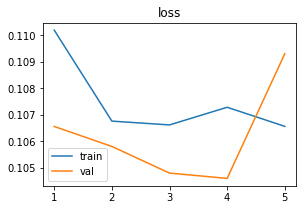

In [88]:
plot_training_stats(stats, metrics=['loss'])

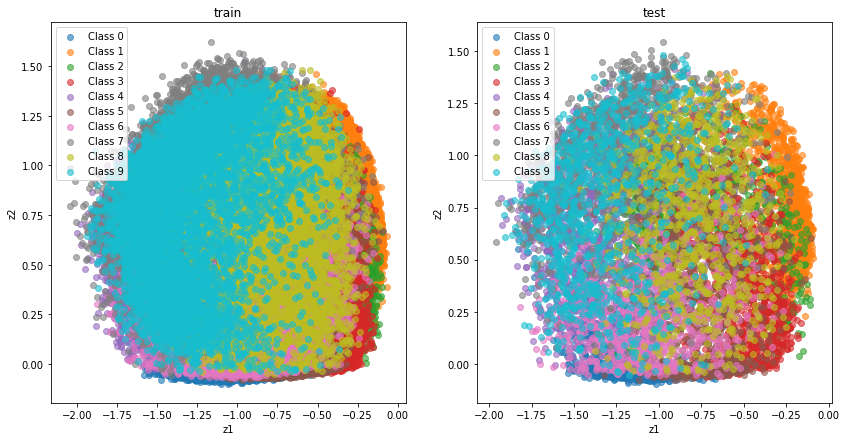

In [89]:
def show_embedding(model, trainloader, testloader):
    test_embedding, test_labels = get_embedding(model, testloader)
    train_embedding, train_labels = get_embedding(model, trainloader)
    plot_embedding(train_embedding, train_labels, test_embedding, test_labels)
    
show_embedding(siamese_model, trainloader, testloader)

![](https://cdn-images-1.medium.com/max/2000/1*tzGB6D97tHWR_-NJ8FKknw.jpeg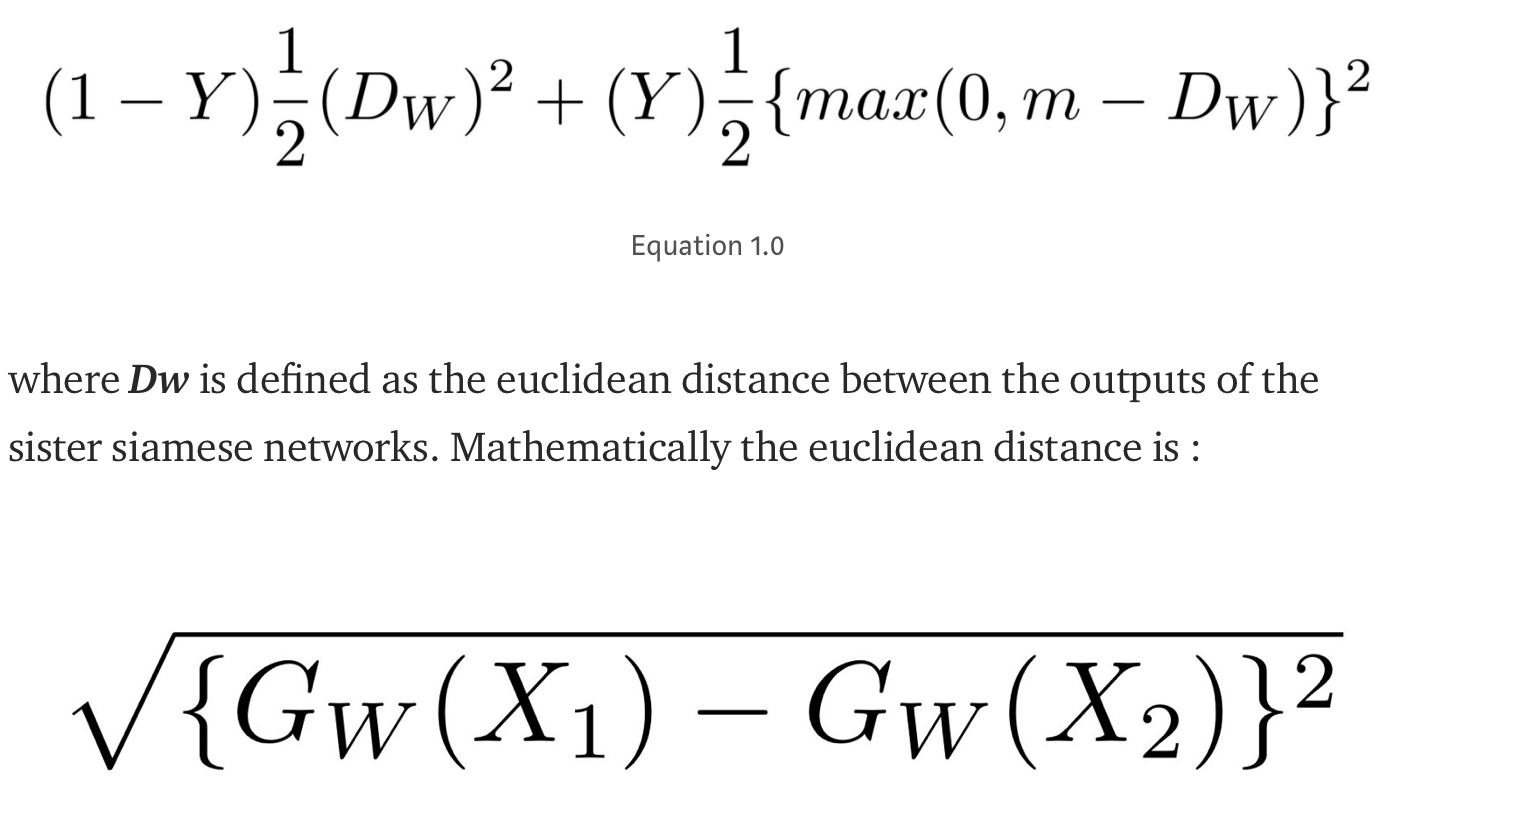)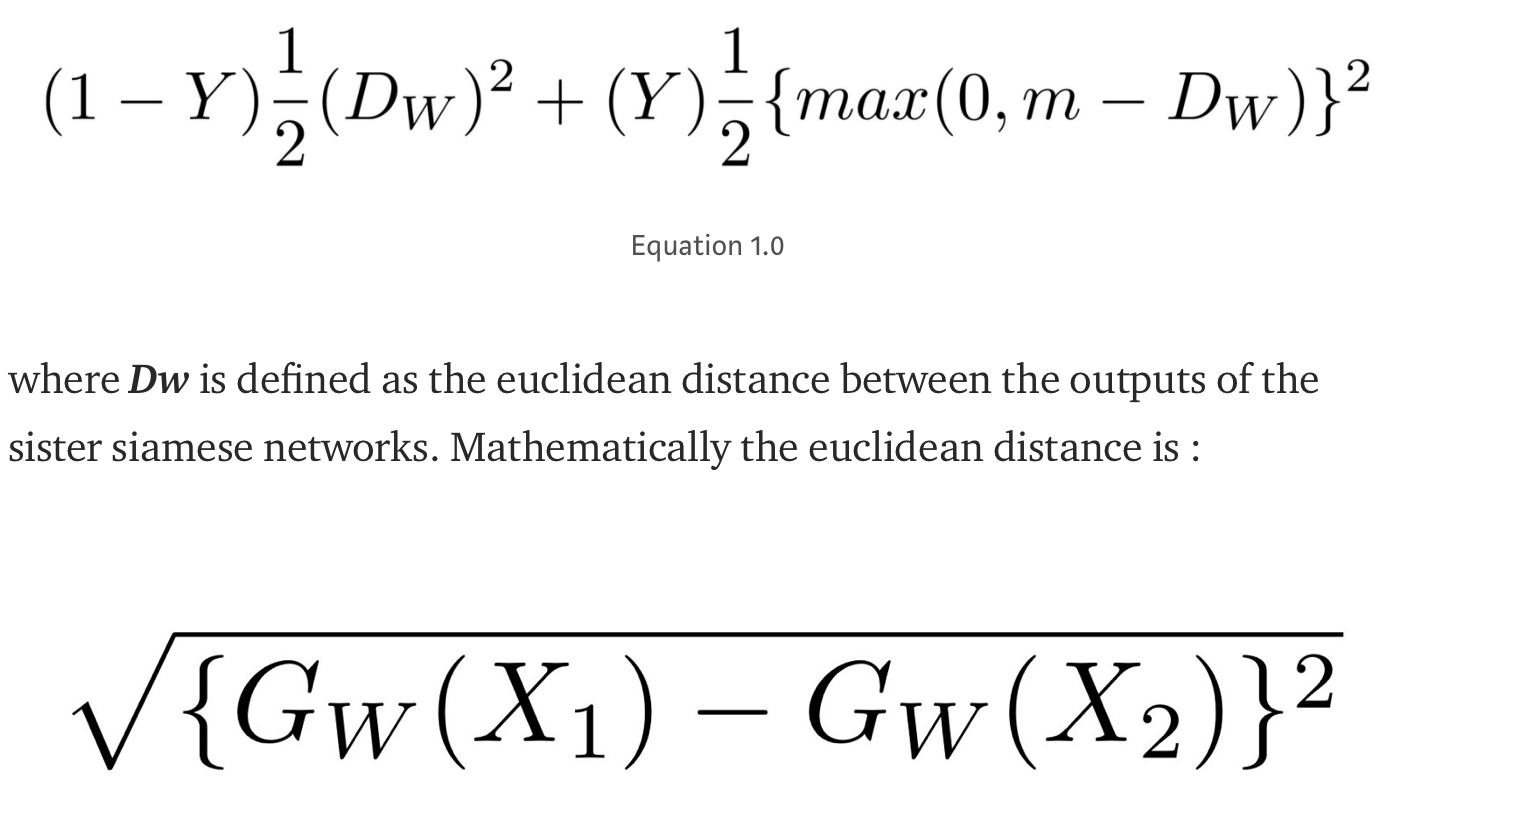

In [ ]:
x = torch.rand(7, 3)
x_hat = torch.rand(7, 3)
Siamese.loss(x, x_hat, torch.tensor([1, 0, -1]))